# Computational Tests

This notebook is intended for running different kinds of analyses that would validate our reconstruction.

[1. Subsystem Overview and Analysis](#subsystems) <br>
[2. Context-specific Model Generation](#context_specific) <br>
[3. Biomass prediction using exp. data](#biomass) <br>
[4. Flux Enrichment Analysis](#fea) <br>

## 1. Subsystem Overview and Analysis <a id='subsystems'></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from google_sheet import GoogleSheet

In [ ]:
##### ----- Generate Subsystems datasets from Google Sheet ----- #####

#Credential file
KEY_FILE_PATH = 'credentials.json'

#CHO Network Reconstruction + Recon3D_v3 Google Sheet ID
SPREADSHEET_ID = '1MlBXeHIKw8k8fZyXm-sN__AHTRSunJxar_-bqvukZws'

# Initialize the GoogleSheet object
sheet = GoogleSheet(SPREADSHEET_ID, KEY_FILE_PATH)

# Read data from the Google Sheet
sheet_subsystems = 'Summary Systems'
subsystems = sheet.read_google_sheet(sheet_subsystems)

# Remove the total count
subsystems = subsystems.iloc[:-1, :]

In [ ]:
#### --- Pie Chart of the Amount of Reactions per System --- ####

subsystems["Number of Reactions"] = pd.to_numeric(subsystems["Number of Reactions"])

# Aggregate data by "System" and sum "Number of Reactions"
system_reactions = subsystems.groupby("System")["Number of Reactions"].sum()

# Set the figure and axes for more control
fig, ax = plt.subplots(figsize=(10, 7))

# Generate the pie chart again with the custom labels
patches, texts, autotexts = ax.pie(system_reactions, labels=system_reactions.index, autopct=lambda p: '{:.1f}%'.format(p) if p > 0 else '', startangle=140, colors=plt.cm.tab20.colors)

# Improve aesthetics
for text in texts + autotexts:
    text.set_color('black')
ax.set_title("Pie Chart of Number of Reactions by System", pad=30)  # Move the title upwards by increasing pad

# Set equal aspect ratio
ax.axis('equal')

# Save the plot
plt.savefig('../Plots/pie_chart_reactions_per_system.png')

# Display the plot
plt.show()

In [ ]:
# Generate the Sunburst Plot

fig = px.sunburst(subsystems, path=['System', 'Subsystems', 'Kegg Pathway'],
                  color='System')

# Convert to a Graph Objects figure
fig_go = go.Figure(fig)

# Update layout
fig_go.update_layout(width=1200, height=1000)

# Define font sizes
font_size_last_layer = 10
font_size_previous_layer = 15
default_font_size = 12

# Create a list to store font sizes
font_sizes = []

# Update font size for each level
for trace in fig_go.data:
    if isinstance(trace, go.Sunburst):
        for id in trace.ids:
            level = id.count("/")  # Determine level by the number of slashes in the id
            if level == 2:  # Last layer (Kegg Pathway)
                font_sizes.append(font_size_last_layer)
            elif level == 1:  # Previous layer (Subsystems)
                font_sizes.append(font_size_previous_layer)
            else:
                font_sizes.append(default_font_size)  # Default size for other layers

# Apply the font sizes to the figure
fig_go.update_traces(insidetextfont=dict(size=font_sizes))

# Save the figure
fig_go.write_html("../Plots/sunburst_subsystems.html")  # Save as interactive HTML file
fig_go.write_image("../Plots/sunburst_subsystems.png", width=1200, height=1000, scale=2)  # Increase resolution by setting scale parameter

# Show the plot
fig_go.show()

#### Auxotrophies

In [ ]:
from cobra.io import load_json_model

iCHO_path = "iCHO3595.json"
iCHO = load_json_model(iCHO_path)

In [ ]:
amino_acids = {
    "arginine": ["EX_arg_L_e", "EX_arg_D_e"],
    "asparagine": ["EX_asn_L_e", "EX_asn_D_e"],
    "cysteine": ["EX_cys_L_e", "EX_cys_D_e", "EX_Lcystin_e"],
    "histidine": ["EX_his_L_e", "EX_his_D_e"],
    "isoleucine": ["EX_ile_L_e", "EX_ile_D_e"],
    "leucine": ["EX_leu_L_e", "EX_leu_D_e"],
    "lysine": ["EX_lys_L_e", "EX_lys_D_e"],
    "methionine": ["EX_met_L_e", "EX_met_D_e"],
    "phenylalanine": ["EX_phe_L_e", "EX_phe_D_e"],
    "proline": ["EX_pro_L_e", "EX_pro_D_e"],
    "threonine": ["EX_thr_L_e", "EX_thr_D_e"],
    "tryptophan": ["EX_trp_L_e", "EX_trp_D_e"],
    "valine": ["EX_val_L_e", "EX_val_D_e"]
}
for amino_acid in amino_acids:
    # ----- Setup initial bounds -----
    for exchange_reaction in iCHO.exchanges:
        exchange_reaction.bounds = -10, 10

    # Arginine
    iCHO.reactions.get_by_id('GAUGE-R00557').bounds = 0, 10
    iCHO.reactions.get_by_id('GAUGE-R10107').bounds = 0, 0
    iCHO.reactions.get_by_id('GAUGE-R00558').bounds = 0, 0
    iCHO.reactions.get_by_id('GLYAMDTRc').bounds = 0, 0
    iCHO.reactions.get_by_id('GAUGE-R10107').bounds = 0, 0
    iCHO.reactions.get_by_id('EX_valarggly_e').bounds = 0, 10
    iCHO.reactions.get_by_id('ARGSL').bounds = 0, 0

    # Asparigine
    iCHO.reactions.get_by_id('ASNS1').bounds = 0, 0

    # Cysteine
    iCHO.reactions.get_by_id('r0129').bounds = 0, 0
    iCHO.reactions.get_by_id('EX_cgly_e').bounds = 0, 0
    iCHO.reactions.get_by_id('AMPTASECG').bounds = -10, 0
    iCHO.reactions.get_by_id('AMPTASECGe').bounds = -10, 0
    iCHO.reactions.get_by_id('CYSTGL').bounds = -10, 0
    iCHO.reactions.get_by_id('EX_HC00250_e').bounds = 0, 0
    iCHO.reactions.get_by_id('EX_sfcys_e').bounds = 0, 0

    # Histidine
    iCHO.reactions.get_by_id('VALTRPVALr').bounds = 0,0 

    # Isoleucine - DONE
    iCHO.reactions.get_by_id('EX_CE2916_e').bounds = 0,0 
    iCHO.reactions.get_by_id('EX_CE2915_e').bounds = 0,0 
    iCHO.reactions.get_by_id('ILETA').bounds = 0, 10
    iCHO.reactions.get_by_id('ILETAm').bounds = 0, 10

    # Leucine
    iCHO.reactions.get_by_id('LEULEULAPc').bounds = 0,0 
    iCHO.reactions.get_by_id('EX_leugly_e').bounds = 0,0 
    iCHO.reactions.get_by_id('EX_glyleu_e').bounds = 0,0 
    iCHO.reactions.get_by_id('LEUTA').bounds = 0, 10 
    iCHO.reactions.get_by_id('LEUTAm').bounds = 0, 10 
    iCHO.reactions.get_by_id('EX_CE5797_e').bounds = 0, 0

    # Lysine
    iCHO.reactions.get_by_id('EX_biocyt_e').bounds = 0,0 

    # Methionine
    iCHO.reactions.get_by_id('METS').bounds = -10, 0 
    iCHO.reactions.get_by_id('BHMT').bounds = -10, 0 
    iCHO.reactions.get_by_id('GAUGE-R00648').bounds = 0, 10 
    iCHO.reactions.get_by_id('UNK2').bounds = -10, 0 
    iCHO.reactions.get_by_id('UNK3').bounds = -10, 0 
    iCHO.reactions.get_by_id('TYRA').bounds = -10, 0 
    #iCHO.reactions.get_by_id('GAUGE-R06895').bounds = 0, 0 # Curated by MR with 1 score / Erased from the reconstruction

    # Phenylalanine
    iCHO.reactions.get_by_id('EX_CE5786_e').bounds = 0, 0 
    iCHO.reactions.get_by_id('EX_pheleu_e').bounds = 0, 0 
    iCHO.reactions.get_by_id('EX_glyphe_e').bounds = 0, 0 
    iCHO.reactions.get_by_id('EX_CE2917_e').bounds = 0, 0 
    iCHO.reactions.get_by_id('EX_CE5786_e').bounds = 0, 0 
    iCHO.reactions.get_by_id('EX_CE5789_e').bounds = 0, 0 
    iCHO.reactions.get_by_id('EX_phpyr_e').bounds = 0, 0 

    # Proline
    iCHO.reactions.get_by_id('EX_glypro_e').bounds = 0, 10
    iCHO.reactions.get_by_id('EX_progly_e').bounds = 0, 10
    iCHO.reactions.get_by_id('P5CR').bounds = 0, 0
    iCHO.reactions.get_by_id('P5CRxm').bounds = 0, 0
    iCHO.reactions.get_by_id('P5CRx').bounds = 0, 0
    iCHO.reactions.get_by_id('P5CRm').bounds = 0, 0
    iCHO.reactions.get_by_id('r1453').bounds = 0, 10

    # Threonine
    #iCHO.reactions.get_by_id('THRS').bounds = 0,0  # Erased from the reconstruction


    # Tryptophan
    iCHO.reactions.get_by_id('NBAHH_ir').bounds = 0,0  # Histidine hydrolase

    # Valine
    iCHO.reactions.get_by_id('EX_valarggly_e').bounds = 0, 10
    iCHO.reactions.get_by_id('EX_vallystyr_e').bounds = 0, 10
    iCHO.reactions.get_by_id('VALTA').bounds = 0, 10
    iCHO.reactions.get_by_id('VALTAm').bounds = 0, 10
    iCHO.reactions.get_by_id('EX_valval_e').bounds = 0, 10
    # -----------------------------------------

    for exchange_reaction in iCHO.exchanges:
        if exchange_reaction.id in amino_acids[amino_acid]:
            exchange_reaction.bounds = 0, 10
            # print(amino_acid, exchange_reaction.id, amino_acids[amino_acid])
    sol = iCHO.optimize()
    print(amino_acid, sol.objective_value)


In [ ]:
iCHO.metabolites.leu_L_c.summary()

#### Gene Deletion test

In [ ]:
import pandas as pd
from cobra.io import load_json_model, read_sbml_model
from cobra.flux_analysis import single_gene_deletion

#iCHO = load_json_model('iCHO3595_unblocked.json')
#iCHO1766 = read_sbml_model('../Data/Reconciliation/models/iCHOv1_final.xml')
iCHO2291 = read_sbml_model('../Data/Reconciliation/models/iCHO2291.xml')
#iCHO2441 = read_sbml_model('../Data/Reconciliation/models/iCHO2441.xml')

In [ ]:
gene_deletion_results = single_gene_deletion(iCHO2291)
essentiality_threshold = 0.01
essential_genes = gene_deletion_results[gene_deletion_results['growth'] < essentiality_threshold]

In [ ]:
# Print the essential genes
print(f"Number of essential genes for biomass: {len(essential_genes)}")
print("Essential genes for biomass production:")
for gene_idx in essential_genes.index:
    gene = iCHO2291.genes[gene_idx]
    print(f"{gene.id}: {gene.name}")

In [ ]:
from cobra.flux_analysis.variability import find_essential_genes

In [ ]:
sim_essential_genes = find_essential_genes(model)

In [ ]:
# Load the dataset for the experimentally validated essential genes

exp_essential_genes = pd.read_csv('../Data/Gene_Essentiality/cho_essential_genes.csv', sep='\t')
exp_essential_genes['gene'] = exp_essential_genes['gene'].str.replace('__1$', '', regex=True)

In [ ]:
exp_essential_genes

In [ ]:
# Extract all gene names
all_gene_names = set()
for names in exp_essential_genes['gene']:
    for name in names.split('|'): #Extract the names of the genes with two aliases
        all_gene_names.add(name)

In [ ]:
essential_genes_model = []
for g in model.genes:
    if g.name in all_gene_names:
        essential_genes_model.append(g)

In [ ]:
set1 = set(sim_essential_genes)
set2 = set(essential_genes_model)

# Find shared elements
shared_elements = set1.intersection(set2)

# Find unique elements
unique_in_list1 = set1.difference(set2)
unique_in_list2 = set2.difference(set1)

In [ ]:
print("Shared genes between Exp Validated Essential Genes and Simulated Essential Genes:", len(shared_elements))
print("Unique genes in Simulated Essential Genes:", len(unique_in_list1))
print("Unique genes in Exp Validated Essentail Genes:", len(unique_in_list2))

##### Essential for growth genes and comparison to (An optimised genome-wide, virus free CRISPR screen for mammalian cells)
https://pubmed.ncbi.nlm.nih.gov/34935002/

## 2. Context-specific Model Generation <a id='context_specific'></a>

Here we use a matrix generated with rmf_CADRE to generate each context_specific model for each one of the conditions.

In [ ]:
import pickle
import pandas as pd
from scipy.io import loadmat
from time import process_time

import pymCADRE
from pymCADRE.rank import rank_reactions
from pymCADRE.check import check_model_function
from pymCADRE.prune import prune_model

import cobra
from cobra.io import load_json_model

### Define Intervals for Context-specific model generation
Here we define the set of constraints in the uptake and secretion rates that we want to incorporate to our context specific models

#### Model Loading and Constraining

In [ ]:
# Load generic model
model = load_json_model('iCHO3595_unblocked.json')

In [ ]:
# Load uptake and secretion rate "Intervals dict

with open('../Data/Uptake_Secretion_Rates/uptake_secretion_intrvl_wt_dict.pkl', 'rb') as file:
    uptsec_intrvl_wt = pickle.load(file)

with open('../Data/Uptake_Secretion_Rates/uptake_secretion_intrvl_zela_dict.pkl', 'rb') as file:
    uptsec_intrvl_zela = pickle.load(file)

In [ ]:
temp_dict = uptsec_intrvl_zela
time = 'P2 to P4'

with model as model:
    model.reactions.biomass_cho_s.bounds = temp_dict['exp_growth_rate'][time]
    for rxn in model.boundary:
        
        # Models that are forced to secrete ethanol are not feasible
        if rxn.id == 'EX_etoh_e':
            rxn.bounds = (-0.1,0.1)
            continue

        # Replace the lower and upper bound with experimental data
        if rxn.id in temp_dict.keys():
            rxn.bounds = temp_dict[rxn.id][time]
            continue
        
        # Keep boundaries open for essential metabolites
        if rxn.id == 'EX_h2o_e':
            rxn.bounds = (-1000,1000)
            continue
        if rxn.id == 'EX_h_e':
            rxn.bounds = (-1000,1000)
            continue
        if rxn.id == 'EX_o2_e':
            rxn.bounds = (-1000,1000)
            continue
        if rxn.id == 'EX_hco3_e':
            rxn.bounds = (-1000,1000)
            continue
        if rxn.id == 'EX_so4_e':
            rxn.bounds = (-1000,1000)
            continue
        if rxn.id == 'EX_pi_e':
            rxn.bounds = (-1000,1000)
            continue

        # Boundaries from Sink reactions on iCHO_v1 (100 times lower)
        if rxn.id == 'SK_Asn_X_Ser_Thr_r':
            rxn.bounds = (-0.001,1000)
            continue
        if rxn.id == 'SK_Tyr_ggn_c':
            rxn.bounds = (-0.001,1000)
            continue
        if rxn.id == 'SK_Ser_Thr_g':
            rxn.bounds = (-0.001,1000)
            continue
        if rxn.id == 'SK_pre_prot_r':
            rxn.bounds = (-0.0006,1000)
            continue

        # Close uptake rates for the rest of the boundaries
        if rxn.id.startswith("EX_"):
            rxn.bounds = (0,1000) 
        if rxn.id.startswith("SK_"):
            rxn.bounds = (0,1000)
        if rxn.id.startswith("DM_"):
            rxn.bounds = (0,1000)
        
    pfba_solution = cobra.flux_analysis.pfba(model)
    pfba_obj = pfba_solution.fluxes[objective]
    print(pfba_obj)

### Loading Ubiquity and Confidence Scores

In [ ]:
# Load the .mat file
mat_data = loadmat('../Data/Context_specific_models/ubiData.mat')

# Access the ubiData structure
ubiData = mat_data['ubiData']

# Accessing individual fields within ubiData
ubiScores = ubiData['ubiScores'][0, 0]
uScore = ubiData['uScore'][0, 0]
rxns = ubiData['rxns'][0, 0]
Condition = ubiData['Condition'][0, 0]

# Print or process the data as needed
print(ubiScores.shape)
print(uScore.shape)
print(rxns.shape)
print(Condition.shape)

In [ ]:
for i,cond in enumerate(Condition[0]):
    if "WT_P4" in cond[0]:
        print(cond[0], i)
    elif "ZeLa_P4" in cond[0]:
        print(cond[0], i)

In [ ]:
Condition[0][0]

In [ ]:
# Ubiquity score list
U = list(ubiScores[:,0])

In [ ]:
# Conf Score List
conf_scores = pd.read_csv('../Data/Context_specific_models/confidence_scores.csv', header=None).iloc[:, 0].tolist()

In [ ]:
# Protected Reations
high_confidence_reactions = ['biomass_cho_s', 'DNAsyn', 'LipidSyn_cho_s', 'PROTsyn_cho_s', 'RNAsyn_cho_s', 'EX_bhb_e', 'EX_nh4_e', 'EX_ac_e', 'EX_ala_L_e',
    'EX_arg_L_e', 'EX_asn_L_e', 'EX_asp_L_e', 'EX_2hb_e', 'EX_cit_e', 'EX_cys_L_e', 'EX_etoh_e', 'EX_for_e', 'EX_fum_e', 'EX_glc_e', 'EX_glu_L_e',
    'EX_gln_L_e', 'EX_gly_e', 'EX_his_L_e', 'EX_4hpro_e', 'EX_ile_L_e', 'EX_lac_L_e', 'EX_leu_L_e', 'EX_lys_L_e', 'EX_mal_L_e', 'EX_met_L_e',
    'EX_phe_L_e', 'EX_pro_L_e', 'EX_5oxpro_e', 'EX_pyr_e', 'EX_ser_L_e', 'EX_thr_L_e', 'EX_trp_L_e', 'EX_tyr_L_e', 'EX_val_L_e', 'EX_h2o_e',
    'EX_h_e', 'EX_o2_e', 'EX_hco3_e', 'EX_so4_e', 'EX_pi_e', 'SK_Asn_X_Ser_Thr_r', 'SK_Tyr_ggn_c', 'SK_Ser_Thr_g', 'SK_pre_prot_r'
]

### Reduced model generation

In [ ]:
##############################################
# Rank reactions
##############################################

print('Processing inputs and ranking reactions...')
GM, C, NC, P, Z, model_C = rank_reactions(model, U, conf_scores, high_confidence_reactions, method=1)

In [ ]:
# Output the results
print("Generic Model:", GM)
print("Core Reactions:", len(C))
print("Non-Core Reactions:", len(NC))
print("Ranked Non-Core Reactions:", len(P))
print("Zero-Expression Reactions:", len(Z))
print("Core Reactions in Original Model:", len(model_C))

In [ ]:
from cobra.util import create_stoichiometric_matrix

def retrieve_precursor_metabolites(model, protected_rxns):
    """
    Retrieve precursor metabolites from a specified list of reactions in a metabolic model.

    Args:
        model: cobra.Model - The metabolic model.
        protected_rxns: list - A list of reaction IDs for which precursor metabolites need to be retrieved.

    Returns:
        precursor_mets: list - A list of precursor metabolites.
    """

    # Create a list of all the reactions in the model
    model_reactions = [r.id for r in model.reactions]
    
    # Ensure that the protected reactions list is not empty
    if protected_rxns:
        
        #Define a list to store the indices of the protected reactions
        rxn_indices = []
        
        for rxn in protected_rxns:
            # Ensure that the protected reaction is included in the model
            if rxn in model_reactions:
                # Get the indices of the protected reactions in the model, only if the reaction exists
                rxn_indices.append(model.reactions.index(model.reactions.get_by_id(rxn)))

        # Create stoichiometric matrix S
        S = create_stoichiometric_matrix(model)
        
        # Retrieve precursor metabolites: metabolites with a negative coefficient in the stoichiometric matrix
        precursor_mets = [
            model.metabolites[i] 
            for i in range(len(model.metabolites)) 
            if any(S[i, idx] < 0 for idx in rxn_indices)
        ]

        return precursor_mets
    else:
        return []

In [ ]:
precursor_mets = retrieve_precursor_metabolites(model, high_confidence_reactions)

In [ ]:
##################################################
# Define inputs to the model pruning step
##################################################

# Define core vs. non-core ratio threshold for removing reactions
eta = 1 / 3

# Check functionality of generic model
genericStatus = check_model_function(GM, 'required_mets', precursor_mets)[0]
print(genericStatus)

In [ ]:
# Constraint the model with exp data

time = 'P2 to P4'

GM.solver = 'gurobi'
objective = 'biomass_cho_s' # 'biomass_cho'
GM.objective = objective

GM.reactions.biomass_cho_s.bounds = temp_dict['exp_growth_rate'][time]
for rxn in GM.boundary:
    
    # Models that are forced to secrete ethanol are not feasible
    if rxn.id == 'EX_etoh_e':
        rxn.bounds = (-0.1,0.1)
        continue

    # Replace the lower and upper bound with experimental data
    if rxn.id in temp_dict.keys():
        rxn.bounds = temp_dict[rxn.id][time]
        continue
    
    # Keep boundaries open for essential metabolites
    if rxn.id == 'EX_h2o_e':
        rxn.bounds = (-1000,1000)
        continue
    if rxn.id == 'EX_h_e':
        rxn.bounds = (-1000,1000)
        continue
    if rxn.id == 'EX_o2_e':
        rxn.bounds = (-1000,1000)
        continue
    if rxn.id == 'EX_hco3_e':
        rxn.bounds = (-1000,1000)
        continue
    if rxn.id == 'EX_so4_e':
        rxn.bounds = (-1000,1000)
        continue
    if rxn.id == 'EX_pi_e':
        rxn.bounds = (-1000,1000)
        continue

    # Boundaries from Sink reactions on iCHO_v1 (100 times lower)
    if rxn.id == 'SK_Asn_X_Ser_Thr_r':
        rxn.bounds = (-0.001,1000)
        continue
    if rxn.id == 'SK_Tyr_ggn_c':
        rxn.bounds = (-0.001,1000)
        continue
    if rxn.id == 'SK_Ser_Thr_g':
        rxn.bounds = (-0.001,1000)
        continue
    if rxn.id == 'SK_pre_prot_r':
        rxn.bounds = (-0.0006,1000)
        continue

    # Close uptake rates for the rest of the boundaries
    if rxn.id.startswith("EX_"):
        rxn.bounds = (0,1000) 
    if rxn.id.startswith("SK_"):
        rxn.bounds = (0,1000)
    if rxn.id.startswith("DM_"):
        rxn.bounds = (0,1000)
    
pfba_solution = cobra.flux_analysis.pfba(GM)
pfba_obj = pfba_solution.fluxes[objective]
print(pfba_obj)

In [ ]:
if genericStatus:
    print('Generic model passed precursor metabolites test')

    ##############################################################
    # If generic functionality test is passed, prune reactions
    ###############################################################
    print('Pruning reactions...')
    t0 = process_time()
    PM, cRes = prune_model(GM, P, C, Z, eta, precursor_mets, salvage_check=0, method=1)
    # Stop the stopwatch / counter
    t_stop = process_time()
    # compute elapsed time
    pruneTime = t_stop - t0

else:
    print('Generic model failed precursor metabolites test!!')

## 3. Biomass prediction using exp. data <a id='biomass'></a>

In [1]:
import os
import pickle
import pandas as pd

import cobra
from cobra.io import load_json_model, read_sbml_model, load_matlab_model
from cobra.exceptions import Infeasible

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Directory containing context-specific models models
model_directory = '../Data/Context_specific_models/'

# Model Names
wt_model_names = ['WT_P4_Bio141', 'WT_P4_Bio142', 'WT_P4_Bio143','WT_P6_Bio142', 'WT_P6_Bio143']
zela_model_names = ['ZeLa_P2_Bio145', 'ZeLa_P2_Bio146', 'ZeLa_P2_Bio147', 'ZeLa_P2_Bio148',
                    'ZeLa_P4_Bio144', 'ZeLa_P4_Bio145', 'ZeLa_P4_Bio146', 'ZeLa_P4_Bio147', 'ZeLa_P4_Bio148',
                    'ZeLa_P6_Bio144', 'ZeLa_P6_Bio146', 'ZeLa_P6_Bio148',
                    'ZeLa_P8_Bio144', 'ZeLa_P8_Bio145', 'ZeLa_P8_Bio146', 'ZeLa_P8_Bio147', 'ZeLa_P8_Bio148']

# Dictionaries to store the loaded models
wt_models = {}
zela_models = {}

# List all .mat files in the directory
model_files = [f for f in os.listdir(model_directory) if f.endswith('.mat')]

# Iterate through the .mat files and load only the models that match predefined strings
for model_file in model_files:
    # Full path to the model file
    model_path = os.path.join(model_directory, model_file)
    
    # Check if the file corresponds to a WT model
    for model_name in wt_model_names:
        if model_name in model_file:
            wt_models[model_name] = load_matlab_model(model_path)
            wt_models[model_name].id = model_name
            print(f"Loaded WT model: {model_name}")
            break  # Stop checking other names since this file is already processed
    
    # Check if the file corresponds to a ZeLa model
    for model_name in zela_model_names:
        if model_name in model_file:
            zela_models[model_name] = load_matlab_model(model_path)
            zela_models[model_name].id = model_name
            print(f"Loaded ZeLa model: {model_name}")
            break  # Stop checking other names since this file is already processed

Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-04
Loaded ZeLa model: ZeLa_P6_Bio144
Loaded ZeLa model: ZeLa_P8_Bio148
Loaded WT model: WT_P6_Bio143
Loaded ZeLa model: ZeLa_P6_Bio146
Loaded ZeLa model: ZeLa_P6_Bio148
Loaded ZeLa model: ZeLa_P4_Bio145
Loaded WT model: WT_P4_Bio141
Loaded ZeLa model: ZeLa_P4_Bio144
Loaded ZeLa model: ZeLa_P4_Bio146
Loaded WT model: WT_P4_Bio143
Loaded ZeLa model: ZeLa_P2_Bio148
Loaded ZeLa model: ZeLa_P4_Bio148
Loaded ZeLa model: ZeLa_P2_Bio147
Loaded ZeLa model: ZeLa_P2_Bio146
Loaded WT model: WT_P4_Bio142
Loaded ZeLa model: ZeLa_P4_Bio147
Loaded ZeLa model: ZeLa_P2_Bio145
Loaded WT model: WT_P6_Bio142
Loaded ZeLa model: ZeLa_P8_Bio146
Loaded ZeLa model: ZeLa_P8_Bio147
Loaded ZeLa model: ZeLa_P8_Bio145
Loaded ZeLa model: ZeLa_P8_Bio144


### Simulations

In [3]:
# Load uptake and secretion rate dict

with open('../Data/Uptake_Secretion_Rates/uptake_secretion_raw_wt_dict.pkl', 'rb') as file:
    uptsec_wt = pickle.load(file)

with open('../Data/Uptake_Secretion_Rates/uptake_secretion_raw_zela_dict.pkl', 'rb') as file:
    uptsec_zela = pickle.load(file)

In [4]:
# Sanity Check. Make sure all the exchange reactions in the experimental data are present in the model and that the models ar growing

for name,model in zela_models.items():
    print('---------------------------------------')
    print(f'------------{model.id}------------')
    print('')
    print(f'Objective:{model.objective}')
    print('')
    print(f'GR: {model.slim_optimize()}')
    exchanges = list(uptsec_wt.keys())
    model_ex = [r.id for r in model.boundary]

    print('')
    print('Missing reactions from exp data:')
    for ex in exchanges:
        if ex not in model_ex:
            print(ex)
    print('---------------------------------------')
    print('---------------------------------------')
    print('')
    print('')


for name,model in wt_models.items():
    print('---------------------------------------')
    print(f'------------{model.id}------------')
    print('')
    print(f'Objective:{model.objective}')
    print('---------------------------------------')
    print(f'GR: {model.slim_optimize()}')
    exchanges = list(uptsec_wt.keys())
    model_ex = [r.id for r in model.boundary]
    
    for ex in exchanges:
        if ex not in model_ex:
            print(ex)
    print('---------------------------------------')
    print('---------------------------------------')
    print('')

---------------------------------------
------------ZeLa_P6_Bio144------------

Objective:Maximize
1.0*biomass_cho_s - 1.0*biomass_cho_s_reverse_dd74e

GR: 0.018563977057166503

Missing reactions from exp data:
EX_mal_L_e
exp_growth_rate
---------------------------------------
---------------------------------------


---------------------------------------
------------ZeLa_P8_Bio148------------

Objective:Maximize
1.0*biomass_cho_s - 1.0*biomass_cho_s_reverse_dd74e

GR: 0.005114923614471306

Missing reactions from exp data:
EX_mal_L_e
exp_growth_rate
---------------------------------------
---------------------------------------


---------------------------------------
------------ZeLa_P6_Bio146------------

Objective:Maximize
1.0*biomass_cho_s - 1.0*biomass_cho_s_reverse_dd74e

GR: 0.018088924148261774

Missing reactions from exp data:
EX_mal_L_e
exp_growth_rate
---------------------------------------
---------------------------------------


---------------------------------------


In [5]:
pfba_solutions_fluxes = []

In [6]:
# WT

results = []

objective = 'biomass_cho_s'

# Adjust the lower bound values according to the experimental growth rates in order to indetify bottlenecks
intervals = {'P0 to P2':'P2', 'P2 to P4':'P4', 'P4 to P6':'P6', 'P6 to P8':'P8', 'P8 to P12':'P12', 'P12 to P14':'P14'}
replicates = {'U1':'Bio141', 'U2':'Bio142', 'U3':'Bio143'}

for name,model in wt_models.items():
    print(f"Processing model: {name}")
    # Set lower bounds of the reactions according to the experimental data
    for interval_key, interval_model_time in intervals.items():
        if interval_model_time in name:  # Match model name with interval
            for rep_key, rep_suffix in replicates.items():
                if rep_suffix in name:  # Match replicate with model name

                     with model as modified_model:

                        # Open the bounds for the biomass reaction 
                        modified_model.reactions.biomass_cho_s.bounds = (0,1000)
                        # INCLUDE ATP DEMAND REACTION atp_c --> bounds = (4.5, 1000)

                        # Create a copy of the modified_model before making changes
                        pre_modification_model = modified_model.copy()
                         
                        for rxn in modified_model.boundary:
                            # Keep boundaries open for essential metabolites
                            if rxn.id in ['EX_h2o_e', 'EX_h_e', 'EX_o2_e', 'EX_hco3_e', 'EX_so4_e', 'EX_pi_e']:
                                rxn.bounds = (-1000, 1000)
                            elif rxn.id in ['SK_Asn_X_Ser_Thr_r', 'SK_Tyr_ggn_c', 'SK_Ser_Thr_g', 'SK_pre_prot_r']:
                                rxn.bounds = (-0.1, 1000)
                            elif rxn.id.startswith(("EX_", "SK_", "DM_")):
                                rxn.bounds = (0, 1000)  # Close uptake rates for others
                        
                        print(f'Calculating Growth Rate for WT Condition:{rep_key,interval_key}')
                        exp_gr = uptsec_wt['exp_growth_rate'][(rep_key,interval_key)]
                        print(f'Experimental growth rate is: {exp_gr}')
                        for reaction in modified_model.reactions:
                            if reaction.id == 'EX_etoh_e': #Model creates infeasible solutions when secreting etoh
                                continue
                            for r,v in uptsec_wt.items():
                                if reaction.id == r:
                                    reaction.upper_bound = 1000
                                    reaction.lower_bound = v[(rep_key,interval_key)]
                                    
                        try:
                            pfba_solution = cobra.flux_analysis.pfba(modified_model)
                            pfba_obj = pfba_solution.fluxes[objective]
                            print(f'Simulated growth rate is: {pfba_obj}')
                            results.append([rep_suffix, interval_key, exp_gr, pfba_obj])
            
                            # Save the solution with metadata
                            pfba_solutions_fluxes.append({
                                "model": modified_model.id,
                                "condition": interval_key,
                                "fluxes": pfba_solution.fluxes
                            })
                            
                        except Infeasible:
                            print(f'Infeasible solution for replicate {rep_key} interval {interval_key}')
                            print('Reverting to the original model and retrying pFBA...')
                            pfba_solution = cobra.flux_analysis.pfba(pre_modification_model)
                            pfba_obj = pfba_solution.fluxes[objective]
                            print(f'Simulated growth rate with original model is: {pfba_obj}')
                            results.append([rep_suffix, interval_key, exp_gr, pfba_obj])

                            # Save the solution with metadata
                            pfba_solutions_fluxes.append({
                                "model": pre_modification_model.id,
                                "condition": interval_key,
                                "fluxes": pfba_solution.fluxes
                            })
    
# Creating a DataFrame
df_wt = pd.DataFrame(results, columns=['Hue', 'Category', 'X Axis', 'Y Axis'])

Processing model: WT_P6_Bio143
Read LP format model from file /var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/tmpmlolanbo.lp
Reading time = 0.04 seconds
: 3070 rows, 9074 columns, 40914 nonzeros
Calculating Growth Rate for WT Condition:('U3', 'P4 to P6')
Experimental growth rate is: 0.01611849093438101
Simulated growth rate is: 0.002591343785740287
Processing model: WT_P4_Bio141
Read LP format model from file /var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/tmpd9z_0qyk.lp
Reading time = 0.03 seconds
: 3021 rows, 8990 columns, 40850 nonzeros
Calculating Growth Rate for WT Condition:('U1', 'P2 to P4')
Experimental growth rate is: 0.03278062118952783
Simulated growth rate is: 0.07253920217308205
Processing model: WT_P4_Bio143
Read LP format model from file /var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/tmp6fapk3x3.lp
Reading time = 0.03 seconds
: 3172 rows, 9488 columns, 42756 nonzeros
Calculating Growth Rate for WT Condition:('U3', 'P2 to P4')
Experimental growth rate is: 0.0359787398

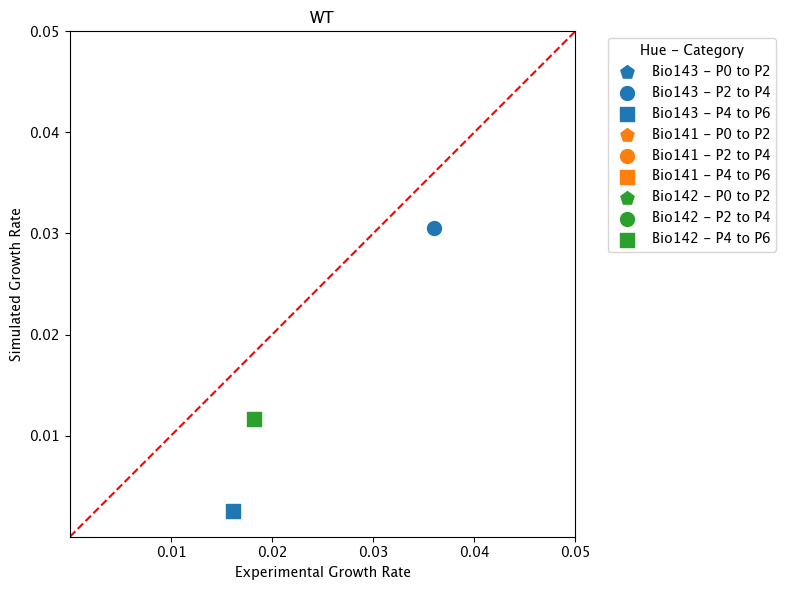

In [7]:
df =df_wt
# Define markers for categories
markers = {
    'P0 to P2': 'p',  # Circle
    'P2 to P4': 'o',  # Circle
    'P4 to P6': 's',   # Square
}

# Set up the plot
plt.figure(figsize=(10, 6))

# Plot each group with different colors for hue and different shapes for categories
hues = df['Hue'].unique()
colors = plt.colormaps.get_cmap('tab10')

for hue_idx, hue in enumerate(hues):
    hue_subset = df[df['Hue'] == hue]
    for category, marker in markers.items():
        subset = hue_subset[hue_subset['Category'] == category]
        plt.scatter(subset['X Axis'], subset['Y Axis'], label=f'{hue} - {category}', marker=marker, s=100, color=colors(hue_idx))

# Add the identity line y = x
plt.plot([0.00, 0.1], [0.00, 0.1], color='red', linestyle='--')

# Set evenly distributed ticks from 0.01 to 0.08
ticks = [i / 100.0 for i in range(1, 11)]
plt.xticks(ticks=ticks, labels=[f'{i/100.0:.2f}' for i in range(1, 11)])
plt.yticks(ticks=ticks, labels=[f'{i/100.0:.2f}' for i in range(1, 11)])

# Set limits for both axes
plt.xlim(0.0, 0.1)
plt.ylim(0.0, 0.1)

# Setting the same scale for both axes
plt.gca().set_aspect('equal', adjustable='box')

# Adding labels and title
plt.xlabel('Experimental Growth Rate')
plt.ylabel('Simulated Growth Rate')
plt.title('WT')
plt.legend(title='Hue - Category', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show plot
plt.tight_layout()
plt.show()

In [8]:
# ZeLa

results = []

objective = 'biomass_cho_s'

# Adjust the lower bound values according to the experimental growth rates in order to indetify bottlenecks
intervals = {'P0 to P2':'P2', 'P2 to P4':'P4', 'P4 to P6':'P6', 'P6 to P8':'P8', 'P8 to P12':'P12', 'P12 to P14':'P14'}
replicates = {'U4':'Bio144', 'U5':'Bio145', 'U6':'Bio146', 'U7':'Bio147', 'U8':'Bio148'}

for name,model in zela_models.items():
    print(f"Processing model: {name}")
    # Set lower bounds of the reactions according to the experimental data
    for interval_key, interval_model_time in intervals.items():
        if interval_model_time in name:  # Match model name with interval
            for rep_key, rep_suffix in replicates.items():
                if rep_suffix in name:  # Match replicate with model name
                    
                     with model as modified_model:

                        # Open the bounds for the biomass reaction 
                        modified_model.reactions.biomass_cho_s.bounds = (0,1000)
                         # INCLUDE ATP DEMAND REACTION atp_c --> bounds = (4.5, 1000)
                         
                        # Create a copy of the modified_model before making changes
                        pre_modification_model = modified_model.copy()
 
                        for rxn in modified_model.boundary:
                            # Keep boundaries open for essential metabolites
                            if rxn.id in ['EX_h2o_e', 'EX_h_e', 'EX_o2_e', 'EX_hco3_e', 'EX_so4_e', 'EX_pi_e']:
                                rxn.bounds = (-1000, 1000)
                            elif rxn.id in ['SK_Asn_X_Ser_Thr_r', 'SK_Tyr_ggn_c', 'SK_Ser_Thr_g', 'SK_pre_prot_r']:
                                rxn.bounds = (-0.1, 1000)
                            elif rxn.id.startswith(("EX_", "SK_", "DM_")):
                                rxn.bounds = (0, 1000)  # Close uptake rates for others

                        print(f'Calculating Growth Rate for ZeLa Condition:{rep_key,interval_key}')
                        exp_gr = uptsec_zela['exp_growth_rate'][(rep_key,interval_key)]
                        print(f'Experimental growth rate is: {exp_gr}')
                        for reaction in modified_model.reactions:
                            if reaction.id == 'EX_etoh_e': #Model creates infeasible solutions when secreting etoh
                                continue
                            for r,v in uptsec_zela.items():
                                if reaction.id == r:
                                    reaction.upper_bound = 1000
                                    reaction.lower_bound = v[(rep_key,interval_key)]
                                    
                        try:
                            pfba_solution = cobra.flux_analysis.pfba(modified_model)
                            pfba_obj = pfba_solution.fluxes[objective]
                            print(f'Simulated growth rate is: {pfba_obj}')
                            results.append([rep_suffix, interval_key, exp_gr, pfba_obj])
            
                            # Save the solution with metadata
                            pfba_solutions_fluxes.append({
                                "model": modified_model.id,
                                "condition": interval_key,
                                "fluxes": pfba_solution.fluxes
                            })
                            
                        except Infeasible:
                            print(f'Infeasible solution for replicate {rep_key} interval {interval_key}')
                            print('Reverting to the original model and retrying pFBA...')
                            pfba_solution = cobra.flux_analysis.pfba(pre_modification_model)
                            pfba_obj = pfba_solution.fluxes[objective]
                            print(f'Simulated growth rate with original model is: {pfba_obj}')
                            results.append([rep_suffix, interval_key, exp_gr, pfba_obj])

                            # Save the solution with metadata
                            pfba_solutions_fluxes.append({
                                "model": pre_modification_model.id,
                                "condition": interval_key,
                                "fluxes": pfba_solution.fluxes
                            })
    
# Creating a DataFrame
df_zela = pd.DataFrame(results, columns=['Hue', 'Category', 'X Axis', 'Y Axis'])

Processing model: ZeLa_P6_Bio144
Read LP format model from file /var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/tmp10op35lx.lp
Reading time = 0.03 seconds
: 3113 rows, 9264 columns, 41688 nonzeros
Calculating Growth Rate for ZeLa Condition:('U4', 'P4 to P6')
Experimental growth rate is: 0.012617780920061862
Simulated growth rate is: 0.012962610769179263
Processing model: ZeLa_P8_Bio148
Read LP format model from file /var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/tmplqkkgzr1.lp
Reading time = 0.03 seconds
: 3130 rows, 9470 columns, 43192 nonzeros
Calculating Growth Rate for ZeLa Condition:('U8', 'P6 to P8')
Experimental growth rate is: 0.007367623359865697
Simulated growth rate is: 0.005792441240800478
Processing model: ZeLa_P6_Bio146
Read LP format model from file /var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/tmp_3ros7a4.lp
Reading time = 0.05 seconds
: 3191 rows, 9602 columns, 43442 nonzeros
Calculating Growth Rate for ZeLa Condition:('U6', 'P4 to P6')
Experimental growth rate i

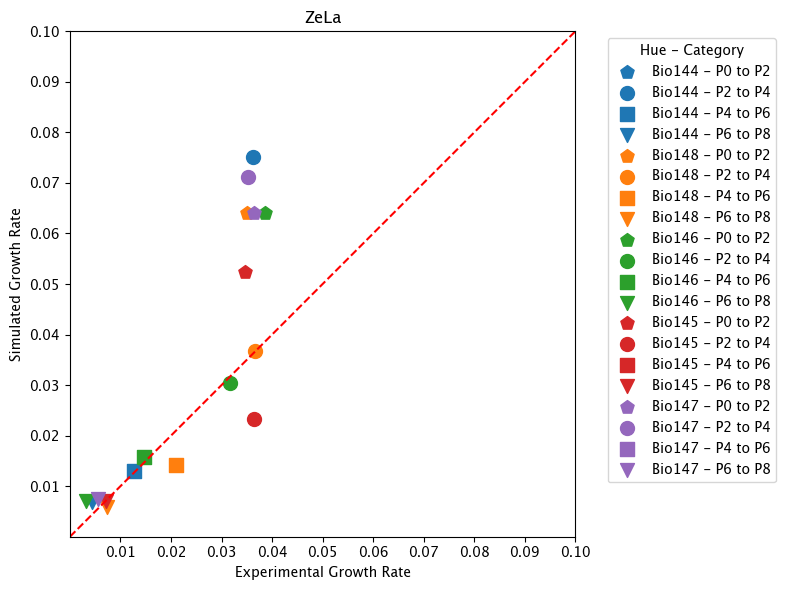

In [9]:
df =df_zela
# Define markers for categories
markers = {
    'P0 to P2': 'p',
    'P2 to P4': 'o',  # Circle
    'P4 to P6': 's',   # Square
    'P6 to P8': 'v',
}

# Set up the plot
plt.figure(figsize=(10, 6))

# Plot each group with different colors for hue and different shapes for categories
hues = df['Hue'].unique()
colors = plt.colormaps.get_cmap('tab10')

for hue_idx, hue in enumerate(hues):
    hue_subset = df[df['Hue'] == hue]
    for category, marker in markers.items():
        subset = hue_subset[hue_subset['Category'] == category]
        plt.scatter(subset['X Axis'], subset['Y Axis'], label=f'{hue} - {category}', marker=marker, s=100, color=colors(hue_idx))

# Add the identity line y = x
plt.plot([0.00, 0.1], [0.00, 0.1], color='red', linestyle='--')

# Set evenly distributed ticks from 0.01 to 0.08
ticks = [i / 100.0 for i in range(1,11)]
plt.xticks(ticks=ticks, labels=[f'{i/100.0:.2f}' for i in range(1, 11)])
plt.yticks(ticks=ticks, labels=[f'{i/100.0:.2f}' for i in range(1, 11)])

# Set limits for both axes
plt.xlim(0.0, 0.1)
plt.ylim(0.0, 0.1)

# Setting the same scale for both axes
plt.gca().set_aspect('equal', adjustable='box')

# Adding labels and title
plt.xlabel('Experimental Growth Rate')
plt.ylabel('Simulated Growth Rate')
plt.title('ZeLa')
plt.legend(title='Hue - Category', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show plot
plt.tight_layout()
plt.savefig('../Plots/bar_plot_growth_rate_zela.png')
plt.show()

In [ ]:
for reaction, values in uptsec_zela.items():
    plt.figure(figsize=(10, 6))
    
    # Organize data for plotting
    batches = sorted(set(k[0] for k in values.keys()))
    timepoints = ['P0 to P2', 'P2 to P4', 'P4 to P6', 'P6 to P8', 'P8 to P12', 'P12 to P14']
    
    for batch in batches:
        batch_data = [values.get((batch, tp), 0) for tp in timepoints]
        plt.plot(timepoints, batch_data, marker='o', label=batch)
    
    plt.title(f'Changes in {reaction} over time')
    plt.xlabel('Timepoints')
    plt.ylabel('Values')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

In [ ]:
for reaction, values in uptsec_wt.items():
    plt.figure(figsize=(10, 6))
    
    # Organize data for plotting
    batches = sorted(set(k[0] for k in values.keys()))
    timepoints = ['P0 to P2', 'P2 to P4', 'P4 to P6', 'P6 to P8', 'P8 to P12', 'P12 to P14']
    
    for batch in batches:
        batch_data = [values.get((batch, tp), 0) for tp in timepoints]
        plt.plot(timepoints, batch_data, marker='o', label=batch)
    
    plt.title(f'Changes in {reaction} over time')
    plt.xlabel('Timepoints')
    plt.ylabel('Values')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

## 4. Flux Enrichment Analysis <a id='fea'></a>

In [ ]:
# OPTION 1
# Use the fluxes from the growth rate calculations to filter reactions with fluxes
# Define a cut off for the flux ??? # Plot to visualization of the flux distribution
# Run Flux Enrichment Analysis on those reactions to see pathways enriched when optimized by biomass

In [ ]:
# OPTION 2
# Transcriptomic data from cell batches / biorreactiors
# Overlay this into the recons and extract the reactions associated to the genes
# Extract a reaction vector / 
# Run Flux Enrichment Analysis

In [ ]:
import cobra
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from scipy.stats import hypergeom
from statsmodels.stats.multitest import multipletests

def flux_enrichment_analysis(generic_model, rxn_list, attribute='subsystem'):
    
    # Check if the attribute exists in the first reaction as a proxy for all
    if not hasattr(model.reactions[0], attribute):
        raise ValueError(f'Attribute {attribute} not found in model reactions')

    # Extract attribute information for all reactions
    attribute_values = [getattr(rxn, attribute, 'None') for rxn in model.reactions]
    unique_attributes = set(attribute_values)
    
    # Count occurrences in the model and in the reaction set
    model_counts = {attr: attribute_values.count(attr) for attr in unique_attributes}
    rxn_set_counts = {attr: 0 for attr in unique_attributes}
    for rxn in rxn_list:
        rxn_attr = getattr(model.reactions.get_by_id(rxn), attribute, 'None')
        rxn_set_counts[rxn_attr] += 1

    # Calculate p-values using hypergeometric test
    M = len(model.reactions)  # Total number of reactions
    n = len(rxn_list)  # Size of reaction set
    p_values = []
    for attr in unique_attributes:
        N = model_counts[attr]  # Total reactions in group
        x = rxn_set_counts[attr]  # Reactions in group and in set
        p_value = hypergeom.sf(x-1, M, N, n)
        p_values.append(p_value)

    # Adjust p-values for multiple testing
    _, adj_p_values, _, _ = multipletests(p_values, method='fdr_bh')

    # Compile results
    results = pd.DataFrame({
        'Group': list(unique_attributes),
        'P-value': p_values,
        'Adjusted P-value': adj_p_values,
        'Enriched set size': [rxn_set_counts[attr] for attr in unique_attributes],
        'Total set size': [model_counts[attr] for attr in unique_attributes],
    }).sort_values(by='Adjusted P-value')

    return results

### Test 1: FEA on reactions active during growth rate optimization
Use the fluxes from the growth rate calculations to filter reactions with fluxes

In [ ]:
# Generate a vector of active reactions for each one of the conditions

active_reactions = []

for sol in pfba_solutions_fluxes:
    rxns_fluxes = []
    for n,f in sol['fluxes'].items():
        if f != 0:
            rxns_fluxes.append(n)
    
    active_reactions.append({
        "batch": sol['model'],
        "condition": sol['condition'],
        "flux_vector": rxns_fluxes
    })


In [ ]:
# Load generic model
model = load_json_model('iCHO3595_unblocked.json')

In [ ]:
# Generate FEA results for each one of the vectors generated for each condition

fea_results = []

# Load generic model
#model = load_json_model('iCHO3595_unblocked.json')

for fluxes in active_reactions:
    results = flux_enrichment_analysis(model, fluxes['flux_vector'], 'subsystem')
    fea_results.append({
        "Batch": fluxes['batch'],
        "Condition": fluxes['condition'],
        "Results": results
    })

In [ ]:
# Transform p-values to -log10

all_data = pd.DataFrame()

for result in fea_results:
    batch = result['Batch']
    temp_df = result['Results'][['Group', 'P-value']].copy()
    temp_df.columns = ['Group', f'P-value_{batch}']
    if all_data.empty:
        all_data = temp_df
    else:
        all_data = pd.merge(all_data, temp_df, on='Group', how='outer')

# Remove groups with a 0 value in all conditions (assuming a '0' value indicates non-significance)
significant_filter = (all_data.drop(columns='Group') < 0.05).any(axis=1)
filtered_data = all_data[significant_filter]
filtered_data.reset_index(inplace=True, drop=True)

# Transform the p-values
for col in filtered_data.columns:
    if col.startswith('P-value'):
        filtered_data[f'-log10_{col}'] = -np.log10(filtered_data[col])

In [ ]:
from scipy.stats import zscore

# Extract relevant columns for heatmap
heatmap_data = filtered_data[[col for col in filtered_data.columns if col.startswith('-log10')]]

# Clean column names
heatmap_data.columns = heatmap_data.columns.str.replace(r"-log10_P-value_", "", regex=True)

# Normalize the data (z-score)
normalized_data = heatmap_data.apply(zscore, axis=1)

# Prepare heatmap data
normalized_data.index = filtered_data['Group']

# Reorder columns: Group P2, P4, P6, and P8 together
columns_order = []
for phase in ['P2', 'P4', 'P6', 'P8']:
    columns_order.extend([col for col in normalized_data.columns if phase in col])

# Reorder the DataFrame
normalized_data = normalized_data[columns_order]

# Plotting the heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(normalized_data, annot=True, cmap="viridis", cbar_kws={'label': 'Z-score of -log10(P-value)'}, vmin=-1.5, vmax=1.5)
plt.title('Heatmap of Z-score Normalized -log10(P-values) Across Conditions', fontsize=20)
plt.xlabel('Conditions', fontsize=15)
plt.ylabel('Groups', fontsize=15)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

plt.savefig('../Plots/FEA_heatmap_all.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Filter the columns based on the presence of "P2 to P4" or "P4 to P6"
subset_df = heatmap_data.filter(regex='_P4_|_P6_')

# Normalize the data (z-score)
normalized_data = subset_df.apply(zscore, axis=1)

# Prepare heatmap data
normalized_data.index = filtered_data['Group']

# Plotting the heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(normalized_data, annot=True, cmap="viridis", cbar_kws={'label': 'Z-score of -log10(P-value)'}, vmin=-1.5, vmax=1.5)
plt.title('Heatmap of Z-score Normalized -log10(P-values) Across Conditions', fontsize=20)
plt.xlabel('Conditions', fontsize=15)
plt.ylabel('Groups', fontsize=15)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

plt.savefig('../Plots/FEA_heatmap_p2_p6.png', format='png', dpi=300, bbox_inches='tight')
plt.show()